
# Code

#### If the imports fail, run the install_packages notebook

teatment impulse


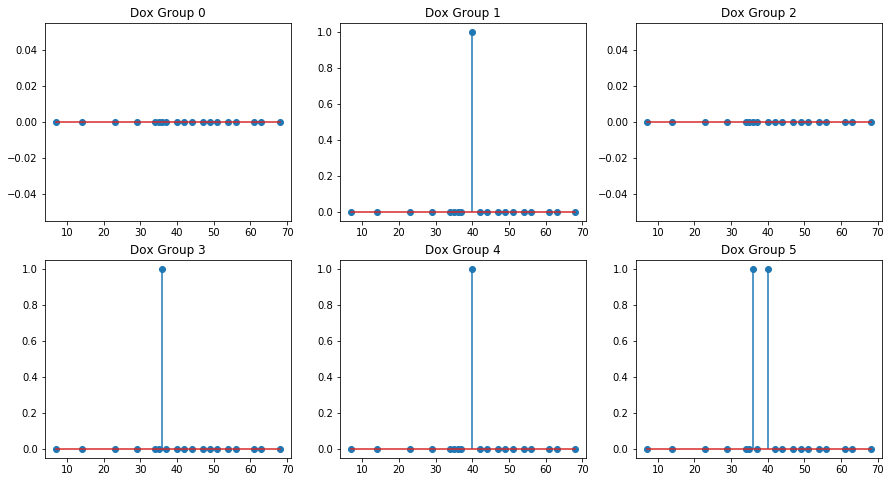

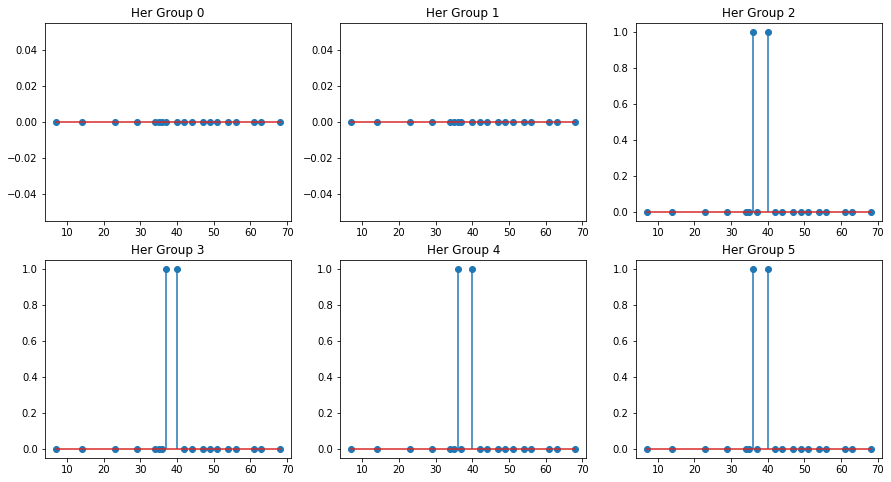

treatment impulse by group


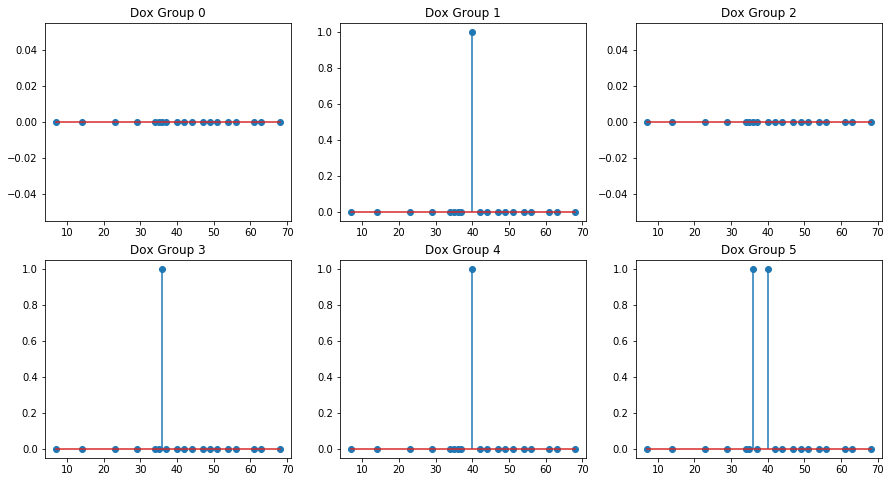

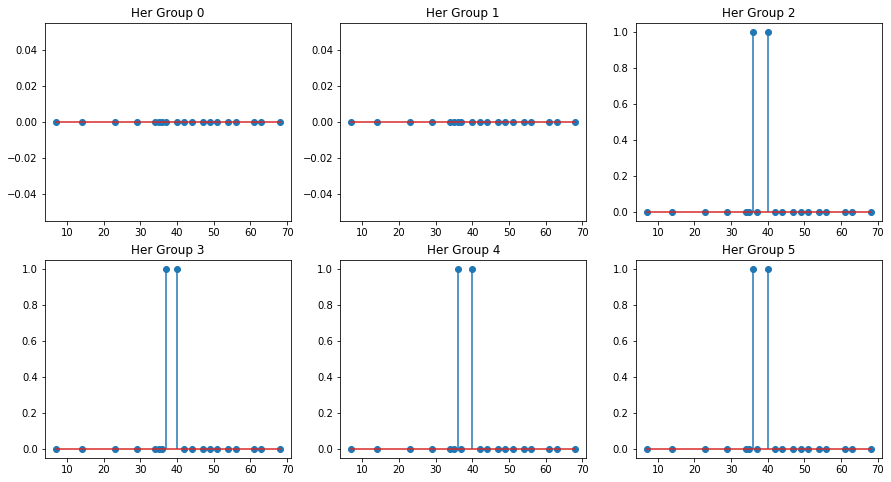

3.8


In [1]:
#data
from get_tumor_db import get_tumor_db
from parse_tumor_db import parse_tumor_db

#visualization
import plot_data

#treatment
import treatment_model as tm

#forward model
import rk_utils

#arrays
import numpy as np

#file system
import os

#CSV read
import pandas as pd

#model building
import pymc3 as pm
print(pm.__version__)
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

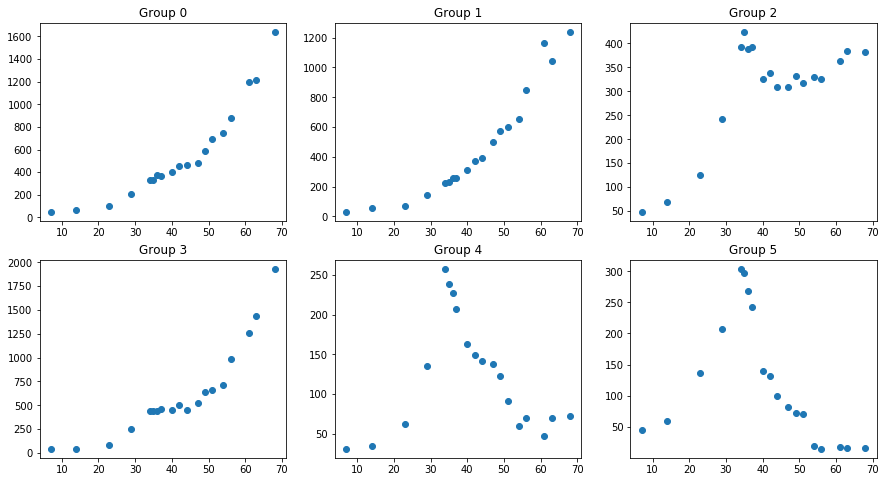

In [2]:
tumor_size_db = get_tumor_db()
ts, Ts, sigmas = parse_tumor_db(tumor_size_db)
plot_data.plot_tumor_data(ts, Ts)

In [3]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

## Growth Model Class

In [5]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0
        
    def dTdt(self, *argv):
        return 0
    def dDdt(self, *argv):
        return 0
    def dHdt(self, *argv):
        return 0
    def dOdt(self, *argv):
        return 0
    
    def rk_T(self, *argv):
        return 0
    def rk_D(self, *argv):
        return 0
    def rk_H(self, *argv):
        return 0
    def rk_O(self, *argv):
        return 0

    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Combinational Therapy


$$ \frac{d \phi_t}{dt} = r \phi_t - \lambda_h \phi_h \phi_t  - (\lambda_d + \lambda_{hd} \phi_h ) \phi_d \phi_t $$

$$ \frac{d \phi_d}{dt} = - \tau_d \phi_d + \delta (t - \eta_d) D_d $$

$$ \frac{d \phi_h}{dt} = - \tau_h \phi_h + \delta (t - \eta_h) D_h e^{-\lambda_{dh} \phi_d} $$

r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh


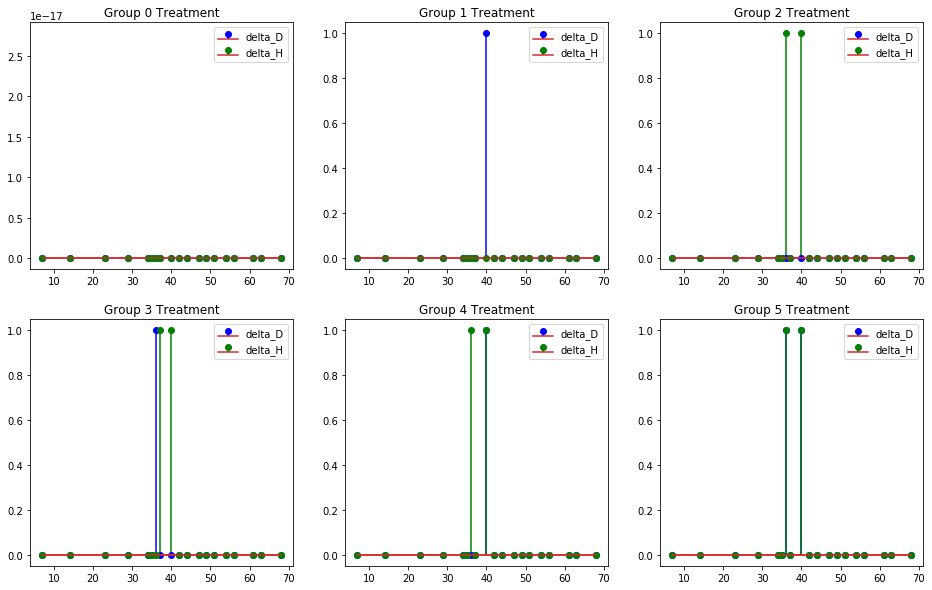

<Figure size 1152x720 with 0 Axes>

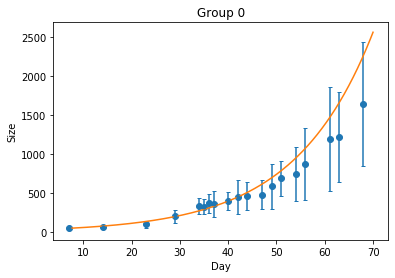

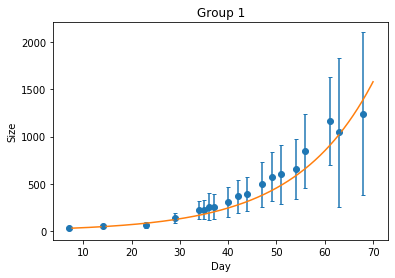

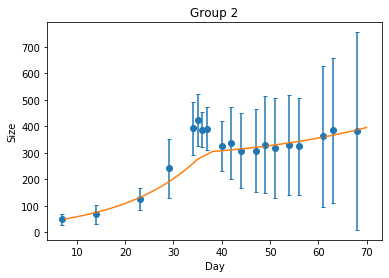

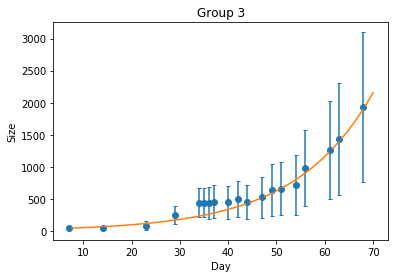

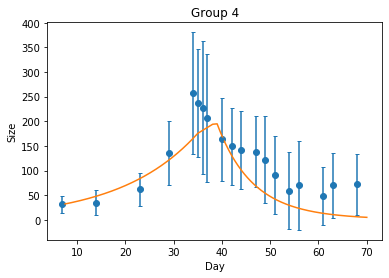

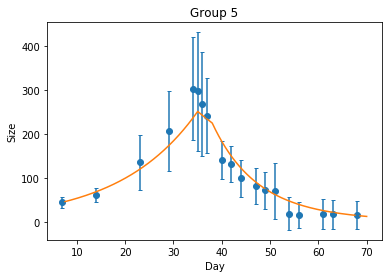

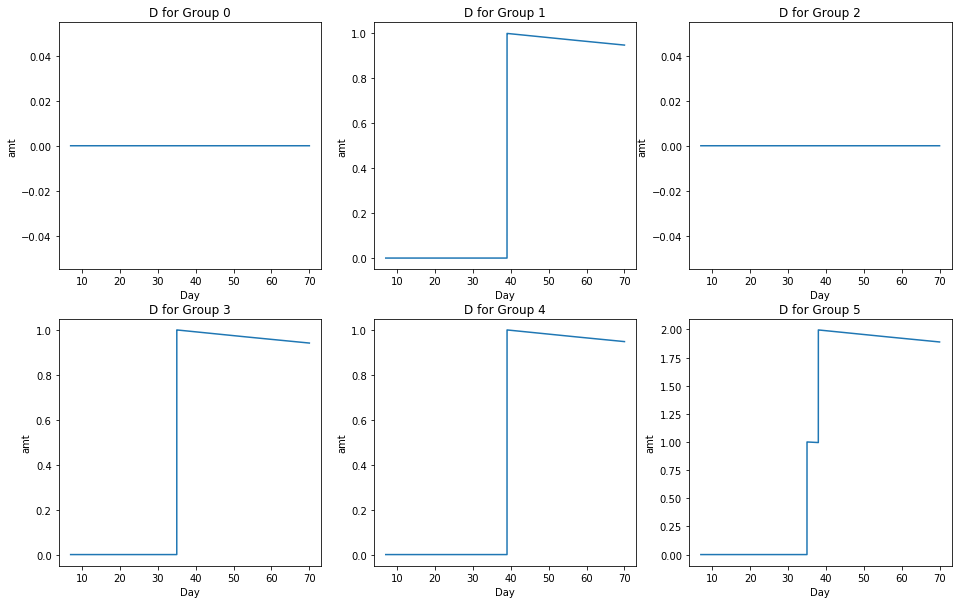

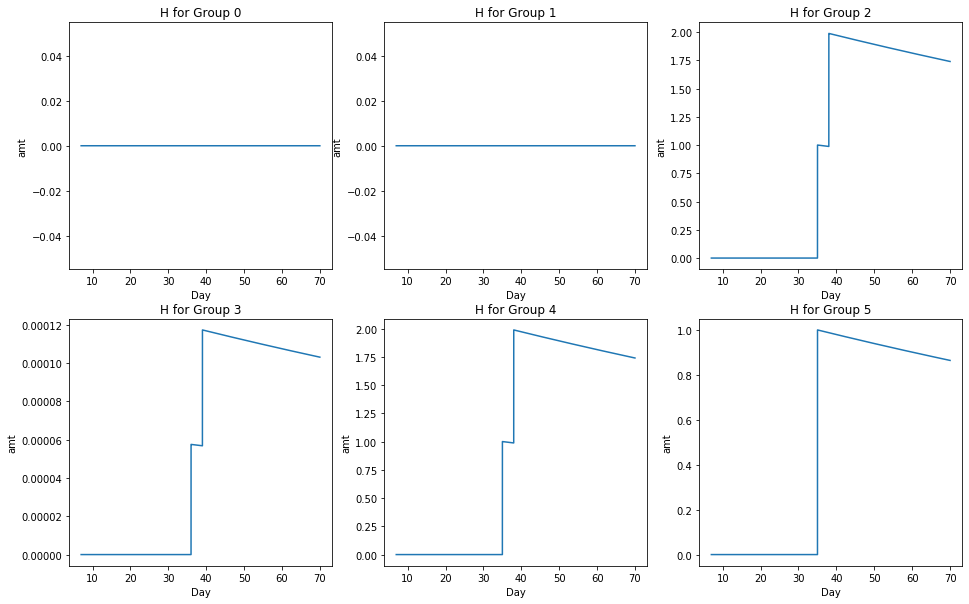

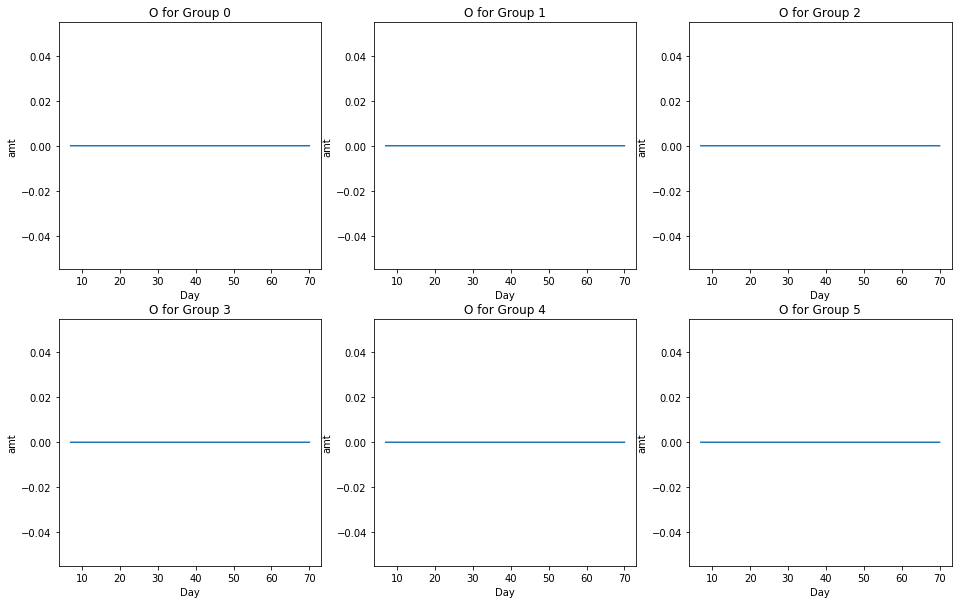

r = 0.0619
lambda_h = 0.0289
lambda_d = 0
lambda_hd = 0.0703
tau_d = 0.00172
tau_h = 0.00417
lambda_dh = 9.78


In [6]:
"""
growth model class must be modified to reflect a new differential equation
list of things that must be changed:

groups
simulate
dTdt, dDdt, etc...
rk_T, rk_D, etc...
in backwards method: param_estimates
th_forward_model
"""


class growth_model_1(growth_model):
    def __init__(self):
        super().__init__(ts, np.array(Ts[:,0]).reshape(-1,))
        
        self.groups, self._times = [0,1,2,3,4,5], ts
        self.Sds_fit, self.Shs_fit = tm.get_Sd_impulse(ts), tm.get_Sh_impulse(ts)
        self.Sds_sim, self.Shs_sim = tm.get_Sd_impulse(sim_times), tm.get_Sh_impulse(sim_times)
        self.Sds, self.Shs = self.Sds_fit, self.Shs_fit 

        self.param_list = ['r', 'lambda_h', 'lambda_d', 'lambda_hd', 'tau_d', 'tau_h', 'lambda_dh']
        
        plot_data.plot_combined_treatment(ts, self.groups, self.Sds, self.Shs)
        
        
    def _simulate(self, fit_params, times):
        #self.sim_T, self.sim_D, self.sim_H, self.sim_O = self.rungeKutta_all_params(times, \
        #                    self._T0, self.dTdt, self.dDdt, self.dHdt, self.dOdt, self.Sds, self.Shs, fit_params)
        self.sim_T, self.sim_D, self.sim_H, self.sim_O = self.rungeKutta_all_params(times, fit_params)
        return self.sim_T
    
    def simulate(self, r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh, times=None):
        if times is None: times = self._times        
        return self._simulate([r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh], times)
    
    #don't take the respective state variable from state_vec here, since runge kutta relies on 
    #the respective state variable being iterated forward
    def dDdt(self, D, state_vec, fit_params):
        #r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = [x for x in params]
        tau_D = fit_params[4]
        return -tau_D*D
    
    def dHdt(self, H, state_vec, fit_params):
        #r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = [x for x in params]
        tau_H = fit_params[5]
        return -tau_H*H
    
    def dOdt(self, O, state_vec, fit_params):
        #r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = [x for x in params]
        return 0
    
    def dTdt(self, T, state_vec, fit_params):
        #r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = [x for x in params]
        r = fit_params[0]
        lambda_h = fit_params[1]
        lambda_d = fit_params[2]
        lambda_hd = fit_params[3]
        D = state_vec[0]
        H = state_vec[1]
        return (r - lambda_h*H - lambda_d*D - lambda_hd * H * D)*T
    
    def rk_T(self, h, state_vec, fit_params):
        T = state_vec[3]
        return rk_utils.rk_X(h, T, state_vec, fit_params, self.dTdt)
    
    def rk_D(self, h, state_vec, fit_params):
        D = state_vec[0]
        return rk_utils.rk_X(h, D, state_vec, fit_params, self.dDdt)
    
    def rk_H(self, h, state_vec, fit_params):
        H = state_vec[1]
        return rk_utils.rk_X(h, H, state_vec, fit_params, self.dHdt)
    
    def rk_O(self, h, state_vec, fit_params):
        O = state_vec[2]
        return rk_utils.rk_X(h, O, state_vec, fit_params, self.dOdt)
    
    
    def rungeKutta_all_params(self, times, fit_params):
        _, _, _, _, _, _, lambda_dh = [x for x in fit_params]
        time_len = len(times.ravel())
        ret_T = np.zeros((self._T0.shape[0], time_len))
        ret_D = np.zeros(ret_T.shape)
        ret_H = np.zeros(ret_T.shape)
        ret_O = np.zeros(ret_T.shape)
        T = self._T0
        D = ret_D[:,0]
        H = ret_H[:,0]
        O = ret_O[:,0]
        ret_T[:, 0] = T
        for i in range(1, time_len):
            h = times[i] - times[i-1]
            Sd = self.Sds[:,i-1]
            Sh = self.Shs[:,i-1]

            state_vec = [D, H, O, T]

            D_new = rk_utils.rk_var_update(D, self.rk_D(h, state_vec, fit_params)) + Sd
            H_new = rk_utils.rk_var_update(H, self.rk_H(h, state_vec, fit_params)) + Sh*np.exp(-lambda_dh*D)
            O_new = rk_utils.rk_var_update(O, self.rk_O(h, state_vec, fit_params))
            T_new = rk_utils.rk_var_update(T, self.rk_T(h, state_vec, fit_params))

            D = D_new
            H = H_new
            O = O_new         
            T = T_new 

            ret_D[:,i] = D
            ret_H[:,i] = H
            ret_O[:,i] = O
            ret_T[:,i] = T

        return ret_T, ret_D, ret_H, ret_O

    def backward(self):
        T_obs = Ts
        sigmas_obs = np.ones(T_obs.shape)
        with pm.Model() as model:
            
            #lower and upper estimates
            param_estimates = {
                'r':[0.0001,0.1],
                'lambda_h': [0.0001, 10],
                'lambda_d': [0.0001, 10],
                'lambda_hd': [0.0001, 10],
                'tau_d': [0.0001, 0.5],
                'tau_h': [0.0001, 0.3],
                'lambda_dh': [0.0001,10]
            }
            
            
            #form priors
            prior_distributions = [pm.Uniform(list(param_estimates.keys())[ii], lower=param_estimates[self.param_list[ii]][0], upper=param_estimates[self.param_list[ii]][1]) for ii in range(len(self.param_list))]
            r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = [x for x in prior_distributions]
           
            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar for x in range(len(self.param_list))], otypes=[tt.dmatrix]) 
            def th_forward_model(r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh):
                th_states = self.simulate(r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh)
                return th_states
            
            forward = th_forward_model(r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh)
            
            
            T = pm.Normal('T', mu=forward, sigma=sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 5
            
            
            #random start positions for MCMC
            startsmc = []
            for _ in range(n_chains):
                startsmc_dict = {}
                for param_name in self.param_list:
                    startsmc_dict[param_name] = np.random.uniform(param_estimates[param_name][0],param_estimates[param_name][1])
                startsmc.append(startsmc_dict)
            
            num_samples = 80 # Within each chain, operations are sequential and cannot be parallelized.
            # if the number of samples drops too low, then the model will throw a negative minors in cholesky factorization
            num_tune = int(num_samples/5)
            #step = pm.SMC()
            
            step = pm.Metropolis()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            """
            self.trace = pm.sample_smc(2000)
            """
            
            pm.traceplot(self.trace)
            #print('log marginal likelihood: ' + str(np.log(model.marginal_likelihood)))
            #pm.compare(self.trace, ic='WAIC')
            #pm.dic(self.trace, model)
            pooled_waic = pm.waic(self.trace, model)
            print(pooled_waic)  
            model.name = 'model1'
            #pm.compare(self.trace)
            self.df_comp_WAIC = pm.compare({model: self.trace})
    
    
    def sim_graph_model():
        sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7
        
        this_model = growth_model_1()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        
        #save0

        r = 6.19e-2
        lambda_h = 2.89e-2
        lambda_d = 0
        lambda_hd = 7.03e-2
        tau_d = 1.72e-3
        tau_h = 4.17e-3
        lambda_dh = 9.78
        
        sim_T = this_model.simulate(r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh, sim_times)
        
        #plot_data.plot_sim(sim_times, sim_T)
        plot_data.plot_sims_vs_actual(this_model.groups, ts, Ts, sigmas, sim_times, sim_T)
        plot_data.plot_D(sim_times, this_model.sim_D)
        plot_data.plot_H(sim_times, this_model.sim_H)
        plot_data.plot_O(sim_times, this_model.sim_O)
        
        print('r = ' + str(r))
        print('lambda_h = ' +str(lambda_h))
        print('lambda_d = ' + str(lambda_d))
        print('lambda_hd = ' + str(lambda_hd))
        print('tau_d = ' + str(tau_d))
        print('tau_h = ' + str(tau_h)) 
        print('lambda_dh = ' + str(lambda_dh))
        
        return r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh
    
    
    def fit_sim_graph_model():
        sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7
        
        this_model = growth_model_1()
        this_model.backward()
        this_model.Sds = this_model.Sds_sim
        this_model.Shs = this_model.Shs_sim
        r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh  = [this_model.get_param(x) for x in this_model.param_list]
        sim_T = this_model.simulate(r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh, sim_times)
        
        #plot_data.plot_sim(sim_times, sim_T)
        plot_data.plot_sims_vs_actual(this_model.groups, ts, Ts, sigmas, sim_times, sim_T)
        plot_data.plot_D(sim_times, this_model.sim_D)
        plot_data.plot_H(sim_times, this_model.sim_H)
        plot_data.plot_O(sim_times, this_model.sim_O)
        
        print('r = ' + str(r))
        print('lambda_h = ' +str(lambda_h))
        print('lambda_d = ' + str(lambda_d))
        print('lambda_hd = ' + str(lambda_hd))
        print('tau_d = ' + str(tau_d))
        print('tau_h = ' + str(tau_h)) 
        print('lambda_dh = ' + str(lambda_dh))
        
        return r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh
    
    
    
r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = growth_model_1.sim_graph_model()

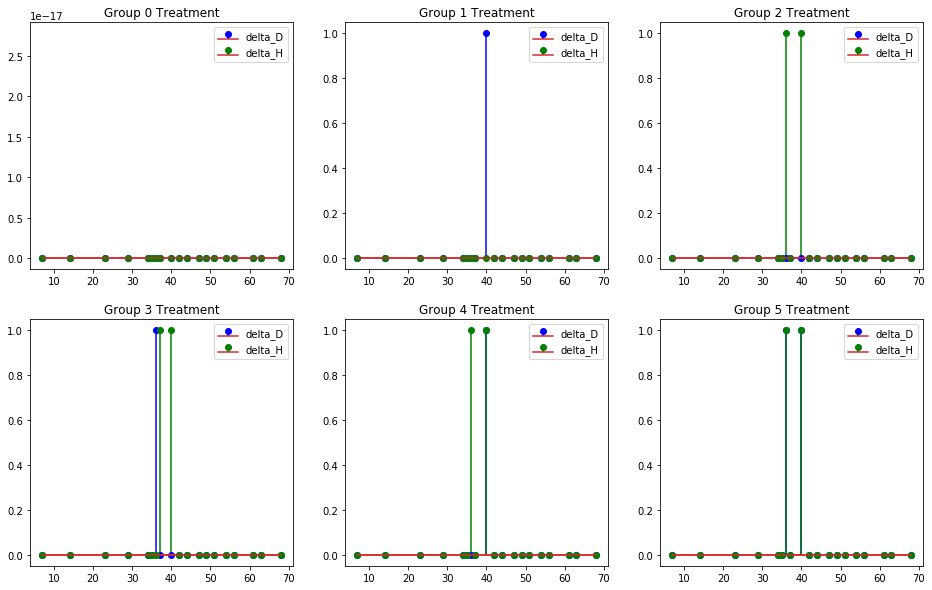

Only 80 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Metropolis: [lambda_dh]
>Metropolis: [tau_h]
>Metropolis: [tau_d]
>Metropolis: [lambda_hd]
>Metropolis: [lambda_d]
>Metropolis: [lambda_h]
>Metropolis: [r]
Sampling chain 4, 0 divergences: 100%|█████████████████████████████████████████████████| 96/96 [00:03<00:00, 28.63it/s]
C:\Users\reidw\Anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
C:\Users\reidw\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\reidw\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplo

C:\Users\reidw\Anaconda3\lib\site-packages\arviz\stats\stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 400 by 114 log-likelihood matrix

        Estimate       SE
IC_waic 1892925068891.82  660839242581.15
p_waic  946462406643.98        -

There has been a warning during the calculation. Please check the results.


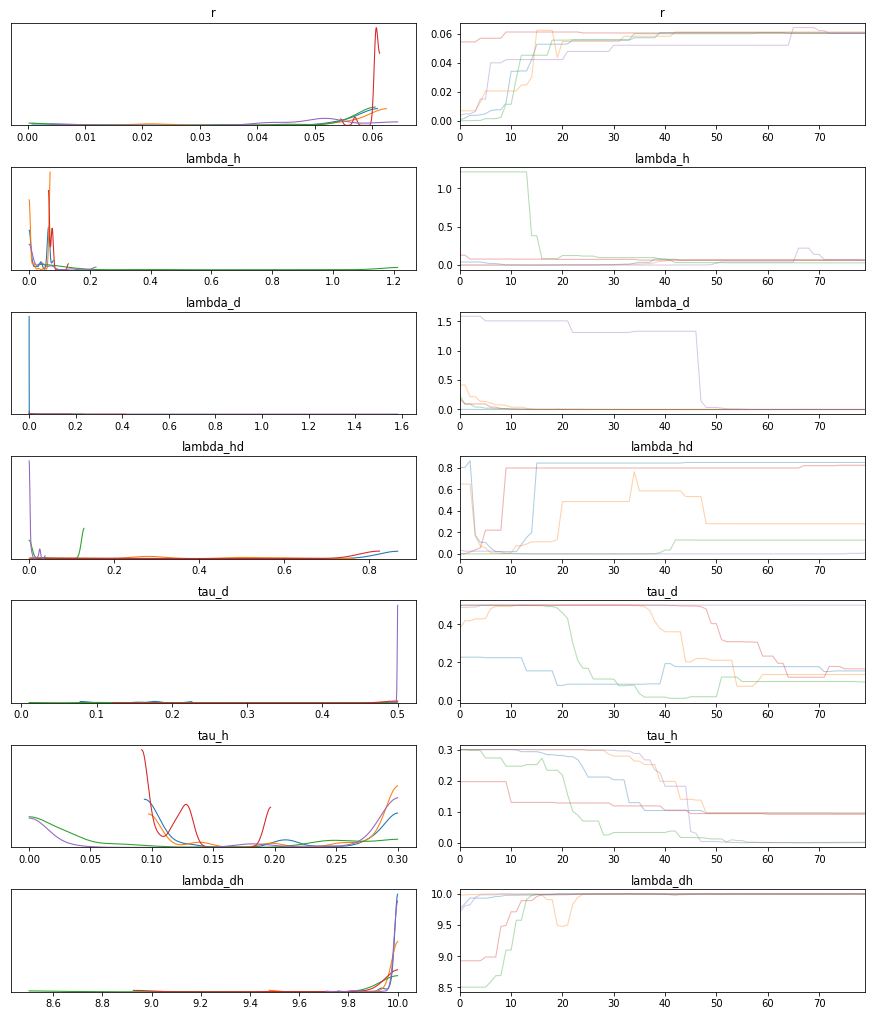

<Figure size 1152x720 with 0 Axes>

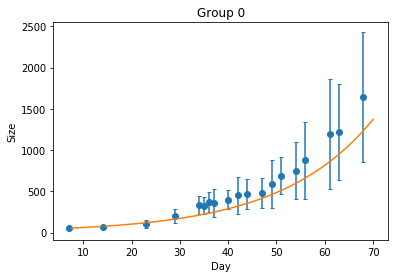

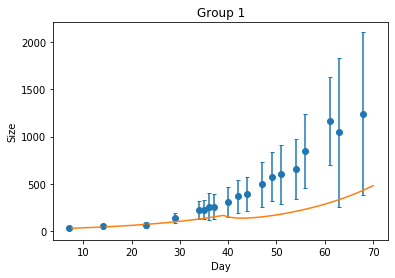

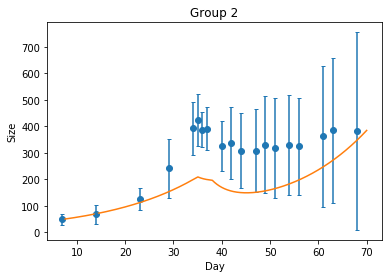

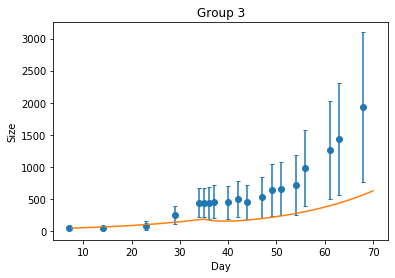

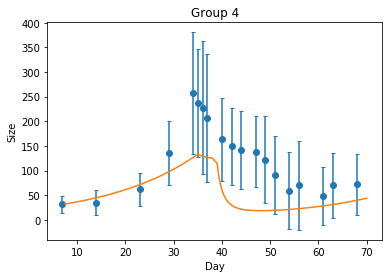

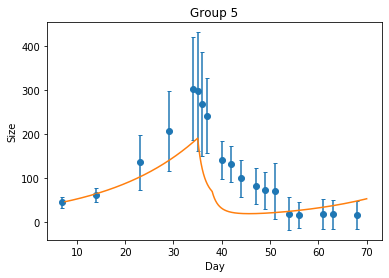

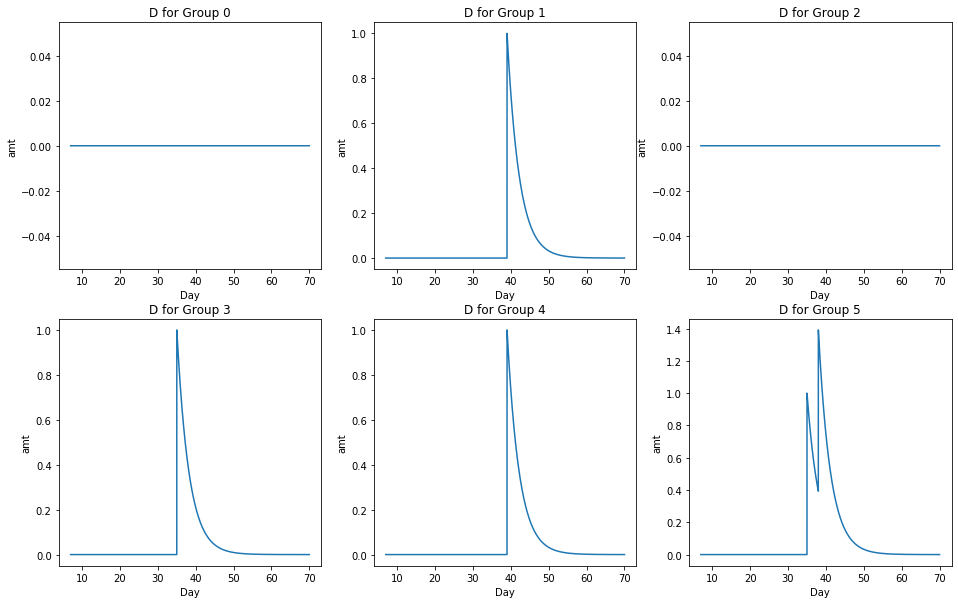

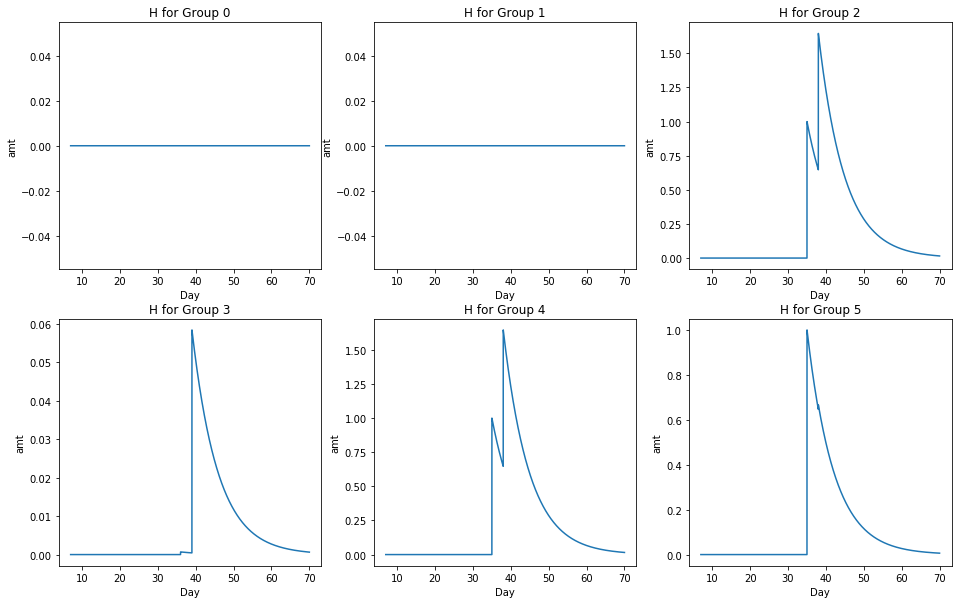

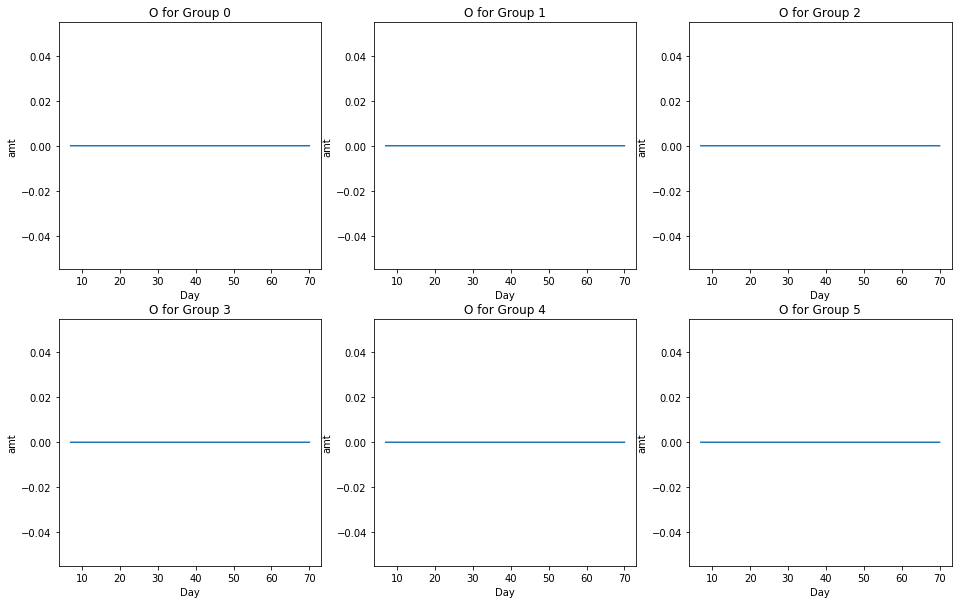

r = 0.052
lambda_h = 0.089
lambda_d = 0.176
lambda_hd = 0.373
tau_d = 0.313
tau_h = 0.146
lambda_dh = 9.924


In [7]:
r, lambda_h, lambda_d, lambda_hd, tau_d, tau_h, lambda_dh = growth_model_1.fit_sim_graph_model()